In [2]:
import sys
import time
import copy

from scipy.stats import norm
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
#tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [17]:
graph = Graph()
#path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
path = "genomics/graph/KEGG.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)


(399, 399)

In [18]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

In [19]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=16, num_layer=2, add_emb=8, use_gate=False, dropout=False, cuda=False):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        self.patience = 10
        self.attention_head = 0
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        if len(set(y_train)) == 1 or len(set(y_test)) == 1: 
            return
        try:
            local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
        except Exception:
            return
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        l1_criterion = torch.nn.L1Loss(size_average=False)

        patience = self.patience
        opt.num_layer = self.num_layer
        #adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)

        if self.model == "CGN":
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=self.attention_head
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
        elif self.model == "SLR":
            model = models.models.SparseLogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    adj=adj, 
                    out_dim=2, 
                    on_cuda=self.cuda)
        elif self.model == "LCG":
            model = models.models.LCG(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj, 
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform, 
                    aggregate_adj=aggregate_function, 
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=nb_attention_head, 
                    training_mode=training_mode)
        elif self.model == 'LR':
            model = models.models.LogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    out_dim=2,
                    on_cuda=self.cuda)
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()
        
        #l1_loss_lambda = 0.0001
        #l1_criterion = torch.nn.L1Loss(size_average=False)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        max_valid_test = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                #l1_loss = setup_l1_loss(model, l1_loss_lambda, l1_criterion, False)
                total_loss = crit_loss #+ l1_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {'train': 0., 'valid': 0., 'test': 0.}
            res = []
            try:
                for base_x in range(0,local_X_train.shape[0], self.batch_size):
                    inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())

                res = []
                for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                    inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())

                res = []
                for base_x in range(0,X_test.shape[0], self.batch_size):
                    inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            except Exception:
                pass
            
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            #print summary

            patience = patience - 1
            if patience == 0:
                return max_valid_test
                break
            if (max_valid < auc['valid']) and t > 5:
                max_valid = auc['valid']
                max_valid_test = auc['test']
                patience = self.patience

In [20]:
def method_comparison(results, dataset, models, gene, num_genes, trials, train_size, test_size):
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    if num_genes != len(dataset.df.columns):
        neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
        dataset.df = dataset.df[list(neighbors)]
        
    dataset.df[gene] = 1
    dataset.data = dataset.df.as_matrix()
    # neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
    neighborhood=None
    for model in models:
        for seed in range(trials):

            #have we already done it?
            already_done = results["df"][(results["df"].gene_name == gene) & 
                                         (results["df"].model == model['key']) &
                                         (results["df"].num_genes == num_genes) &
                                         (results["df"].seed == seed) &
                                         (results["df"].train_size == train_size)].shape[0] > 0

            if already_done:
                print "already done:", model['key'], num_genes, seed
                continue
            print "doing:", model['key'], num_genes, seed

            result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

            experiment = {"gene_name": gene,
                    "model": model['key'],
                    "num_genes": num_genes, 
                    "seed":seed,
                    "train_size": train_size,
                    "auc":result
                    }

            results["df"] = results["df"].append(experiment, ignore_index=True)
            pickle.dump(results, open("results-temp.pkl", "wb"))
    #dataset.df = full_df


In [21]:
import pickle

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},
#    {'key': 'new_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
# {'key': 'wRPL5_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
 #{'key': 'wRPL5_CGN_1_layer_32_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=1, num_channel=32)},
    #{'key': 'MLP-dropout', 'method': PyTorch("MLP", dropout=True, cuda=False)},
    {'key': 'MLP', 'method': PyTorch("MLP", dropout=False, cuda=False)},
    {'key': 'LR', 'method': PyTorch("LR", dropout=False, cuda=False)},
    
    
#{'key': 'SLR', 'method': PyTorch("SLR")},
#   {'key': 'MLP', 'method': PyTorch("MLP", dropout=False)},
    ]



In [22]:
results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [13]:
results = pickle.load(open("results_wednesday_morning_kegg.pkl", "r"))

In [23]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue.df = tcgatissue.df - tcgatissue.df.mean()

Converting one-hot labels to integers


In [47]:
genes_to_iter = tcgatissue.df.columns.difference(results['df']['gene_name'].unique())
genes_to_iter = genes_to_iter.intersection(pd.Series(g.nodes))

7217

In [48]:
full_df = tcgatissue.df.copy(deep=True)
for gene in genes_to_iter:
    tcgatissue.df = full_df[:1500]
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=16300, trials=3, train_size=50, test_size=1000)
    tcgatissue.df = full_df[:1500]
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=50, trials=3, train_size=50, test_size=1000)


doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:188: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1

doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 

doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 1630

doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 

doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: MLP 16300 0
doing: MLP 16300 1
doing: MLP 16300 2
doing: LR 16300 0
doing: LR 16300 1
doing: LR 16300 2
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2

KeyboardInterrupt: 

In [49]:
results

{'df':             auc gene_name model num_genes seed train_size
 0      0.711526      A1BG   MLP     16300    0         50
 1      0.603126      A1BG   MLP     16300    1         50
 2      0.742754      A1BG   MLP     16300    2         50
 3      0.714753      A1BG    LR     16300    0         50
 4      0.660288      A1BG    LR     16300    1         50
 5      0.727019      A1BG    LR     16300    2         50
 6      0.669053      A1BG   MLP        50    0         50
 7      0.576817      A1BG   MLP        50    1         50
 8      0.579492      A1BG   MLP        50    2         50
 9      0.509150      A1BG    LR        50    0         50
 10     0.456098      A1BG    LR        50    1         50
 11     0.493285      A1BG    LR        50    2         50
 12     0.961416      A1CF   MLP     16300    0         50
 13     0.885375      A1CF   MLP     16300    1         50
 14     0.765650      A1CF   MLP     16300    2         50
 15     0.974009      A1CF    LR     16300    0   

NameError: name 'results' is not defined

In [50]:
import pickle
pickle.dump(results, open("results_wednesday_morning-kegg.pkl", "wb"))

In [31]:
#results = pickle.load(open("results.pkl", "r"))

In [84]:
#results["df"] = results["df"].drop(results["df"][results["df"].model == "new_CGN_3_layer_64_channel_emb_32_dropout"].index)

In [51]:
# 4 LINE DATA
std = 0.2
slice_size = 12


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection_mlp = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
intersection_lr = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)
intersection = intersection_lr.intersection(intersection_mlp)

big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1_big_mlp = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)]
line2_small_mlp = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)]
line3_big_lr = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)]
line4_small_lr = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)]

line1 = line1_big_mlp.loc[index_order.tolist()]
line2 = line2_small_mlp.loc[index_order.tolist()]
line3 = line3_big_lr.loc[index_order.tolist()]
line4 = line4_small_lr.loc[index_order.tolist()]


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


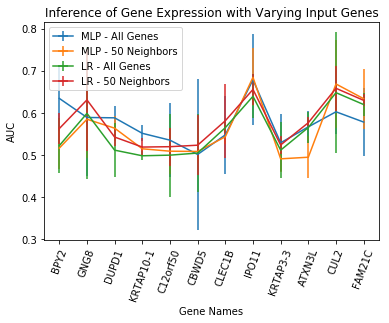

In [52]:
%matplotlib inline
plt.errorbar(range(0, slice_size), line1['mean'], label="MLP - All Genes", xerr=0, yerr=line1_big_mlp['std'])
plt.errorbar(range(0, slice_size), line2['mean'], label="MLP - 50 Neighbors", xerr=0, yerr=line2_small_mlp['std'])
plt.errorbar(range(0, slice_size), line3['mean'], label="LR - All Genes", xerr=0, yerr=line3_big_lr['std'])
plt.errorbar(range(0, slice_size), line4['mean'], label="LR - 50 Neighbors", xerr=0, yerr=line4_small_lr['std'])

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.xticks(np.arange(slice_size), index_order, rotation=70)
plt.legend();

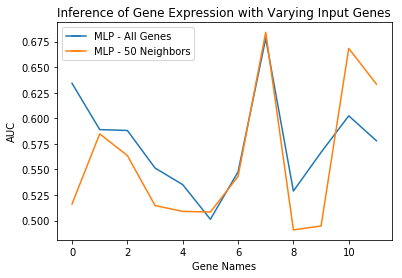

In [53]:
%matplotlib inline
plt.errorbar(range(0, slice_size), line1['mean'], label="MLP - All Genes", xerr=0) #yerr=line1_big_mlp['std'])
plt.errorbar(range(0, slice_size), line2['mean'], label="MLP - 50 Neighbors", xerr=0)#, yerr=line2_small_mlp['std'])

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
#plt.xticks(np.arange(slice_size), index_order, rotation=70)
plt.legend();

In [81]:
# 2 LINE DATA

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 0.20
slice_size = 100000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)


big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

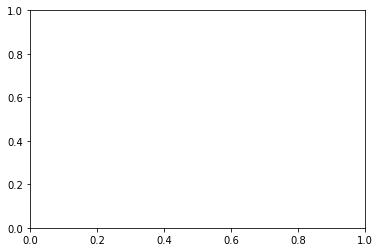

In [78]:
%matplotlib inline
plt.errorbar(range(0, slice_size), line1['mean'], label="MLP - All Genes", xerr=0, yerr=line1['std'])
plt.errorbar(range(0, slice_size), line2['mean'], label="MLP - 50 Neighbors", xerr=0, yerr=line2['std'])

plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.xticks(np.arange(slice_size), index_order, rotation=70)
plt.legend();

None


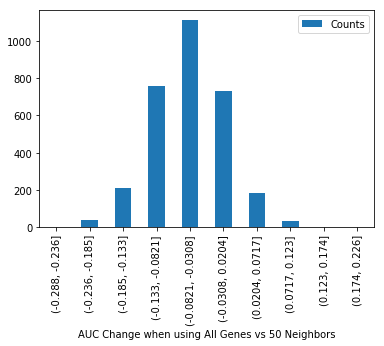

In [79]:
mlp_low_var_high_mean_df['bucket'] = pd.cut(mlp_low_var_high_mean_df['mean'], 10)
newdf = mlp_low_var_high_mean_df[['bucket', 'mean']].groupby('bucket').agg('count')
newdf.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
print newdf.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
newdf.plot(kind='bar')


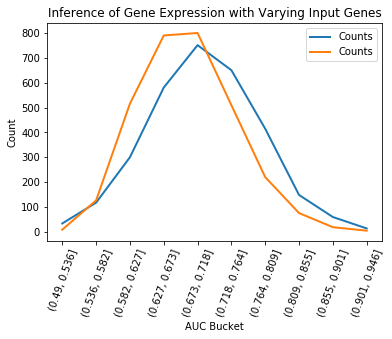

In [80]:
line1['bucket'] = pd.cut(line1['mean'], 10)
line2['bucket'] = pd.cut(line2['mean'], 10)
newdf1 = line1[['bucket', 'mean']].groupby('bucket').agg('count')
newdf2 = line2[['bucket', 'mean']].groupby('bucket').agg('count')
newdf1.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
newdf1.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
newdf2.index.name = 'AUC Change when using All Genes vs 50 Neighbors'
newdf2.rename(index=str, columns={'mean': 'Counts'}, inplace=True)
plt.plot(range(len(newdf1)), newdf1['Counts'], linewidth=2)
plt.plot(range(len(newdf2)), newdf2['Counts'], linewidth=2)
plt.title("Inference of Gene Expression with Varying Input Genes")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")
plt.xticks(range(len(newdf1)), newdf1.index, rotation=70)
plt.legend();

In [89]:
# 2 LINE DATA (Where I tricked myself)

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 0.20
slice_size = 1000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)


big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


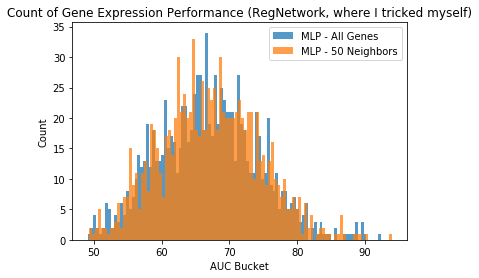

In [90]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (RegNetwork, where I tricked myself)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()


In [91]:
# 2 LINE DATA (MLP Full)

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 0.20
slice_size = 1000000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
#intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)


big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

#big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
#small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
#lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

index_order = mlp_low_var_high_mean_df.index[0:slice_size]
#index_order = lr_low_var_high_mean_df.index[0:slice_size]

line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


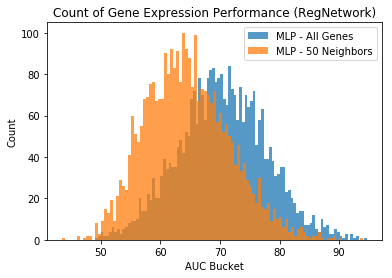

In [92]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (RegNetwork)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()


In [93]:
# 2 LINE DATA (LR)

###### IF you want switch to plotting the LR model instead of the MLP, just flip the commented lines below
std = 0.20
slice_size = 1000000


df = results['df']
grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
small_neighborhood_mlp_df = df[df['num_genes'] == 50][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_mlp_df = df[df['num_genes'] == 16300][df['model']=='MLP'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
small_neighborhood_lr_df = df[df['num_genes'] == 50][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
big_neighborhood_lr_df = df[df['num_genes'] == 16300][df['model']=='LR'].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])

# remove the genes with high variance
small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]
small_neighborhood_lr_df = small_neighborhood_lr_df[small_neighborhood_lr_df['std'] < std]
big_neighborhood_lr_df = big_neighborhood_lr_df[big_neighborhood_lr_df['std'] < std]

# reset the index to the gene names (I don't like working with hierarchical indices)
small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)
small_neighborhood_lr_df.index = small_neighborhood_lr_df.index.get_level_values(0)
big_neighborhood_lr_df.index = big_neighborhood_lr_df.index.get_level_values(0)

# Find the genes which are low variance in the small neighborhood and large neighborhood dfs
#intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)
intersection = big_neighborhood_lr_df.index.intersection(small_neighborhood_lr_df.index)


#big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
#small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
#mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)

big_neighborhood_lr_intersection_df = big_neighborhood_lr_df[big_neighborhood_lr_df.index.isin(intersection)]
small_neighborhood_lr_intersection_df = small_neighborhood_lr_df[small_neighborhood_lr_df.index.isin(intersection)]
lr_low_var_high_mean_df = small_neighborhood_lr_intersection_df.sub(big_neighborhood_lr_intersection_df).sort_values('mean', ascending=False)

#index_order = mlp_low_var_high_mean_df.index[0:slice_size]
index_order = lr_low_var_high_mean_df.index[0:slice_size]

#line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
#line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line1 = big_neighborhood_lr_intersection_df[big_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
line2 = small_neighborhood_lr_intersection_df[small_neighborhood_lr_intersection_df.index.isin(index_order)].loc[index_order.tolist()]



/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


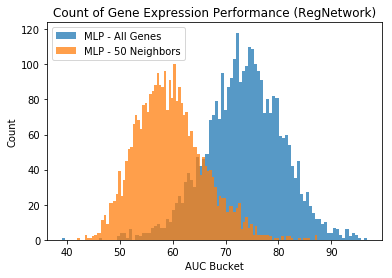

In [94]:
l1 = line1['mean'] * 100
l2 = line2['mean'] * 100
fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

#plt.plot(1000, y1['mean'], 'r--', linewidth=2)
#plt.plot(100, y2, 'b--', linewidth=2)

plt.title("Count of Gene Expression Performance (RegNetwork)")
plt.ylabel("Count")
plt.xlabel("AUC Bucket")

plt.legend()
plt.show()